In [1]:

import re
import pandas as pd
from nltk.corpus import stopwords
import numpy as np
from bs4 import BeautifulSoup
from scipy.sparse import hstack
import random

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Data Exploration 

In [479]:
df = pd.read_excel('AI_Engineer_Dataset_Task_1.xlsx')

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180969 entries, 0 to 180968
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   AcademicYear         180969 non-null  int64 
 1   SemesterName         180969 non-null  object
 2   ParticipantID        180969 non-null  int64 
 3   DegreeLevel          180969 non-null  object
 4   Gender               180969 non-null  object
 5   Nationality          180969 non-null  object
 6   StudentProgram       180969 non-null  object
 7   CourseCode           180969 non-null  object
 8   CourseName           180969 non-null  object
 9   QuestionText         180969 non-null  object
 10  QuestionType         180969 non-null  object
 11  ParticipantResponse  168848 non-null  object
dtypes: int64(2), object(10)
memory usage: 16.6+ MB


In [322]:
df.ParticipantResponse.value_counts()

Strongly Agree                                                                                                                                        88689
Agree                                                                                                                                                 33665
Neutral                                                                                                                                               17639
Strongly Disagree                                                                                                                                     17226
Disagree                                                                                                                                               6391
                                                                                                                                                      ...  
No recommendations, very interesting and useful information for 

# Data Cleaning

Extracted rating info and User Comments from ParticipantResponse into seprate column of Rating and UserComments

In [307]:
df.QuestionType.value_counts()

Rating          163625
User Comment     17344
Name: QuestionType, dtype: int64

In [480]:
df = df.dropna()

In [309]:
df.head()

,AcademicYear,SemesterName,ParticipantID,DegreeLevel,Gender,Nationality,StudentProgram,CourseCode,CourseName,QuestionText,QuestionType,ParticipantResponse
0,2021,Fall 2021 - 2022,7040336900,Bachelor,Female,Palestine,Bachelor of Business Administration,ACC 100,Principles of Accounting,CLO : Evaluate financial and managerial accoun...,Rating,Disagree
1,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The coursework and assignments are challenging,Rating,Strongly Disagree
2,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The course is relevant to my program of study,Rating,Strongly Disagree
3,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,Course learning materials are available on the...,Rating,Strongly Disagree
4,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The faculty uses additional resources (other t...,Rating,Strongly Disagree


In [481]:
# remove nan values from participants' response
df = df[df.ParticipantResponse != 'nan']

In [482]:
df['ParticipantResponse'] = df['ParticipantResponse'].astype(str).str.lower()

In [483]:
# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

In [484]:
df['ParticipantResponse'] = df['ParticipantResponse'].apply(clean)

Divide DataFrame into separate dataframes of Rating and User Comment to apply different techniques of sentiment analysis as rating feedbacks with rating already express classified sentiments

In [485]:
rating_df = df[df['QuestionType']=='Rating']

In [486]:
reviews_df = df[df['QuestionType']=='User Comment']

In [344]:
reviews_df.head()

,AcademicYear,SemesterName,ParticipantID,DegreeLevel,Gender,Nationality,StudentProgram,CourseCode,CourseName,QuestionText,QuestionType,ParticipantResponse
32,2022,Spring 2022 - 2023,6047000700,Bachelor,Male,Syria,Bachelor of Arts in Media and Mass Communication,ACC 100,Principles of Accounting,Do you have any recommendations or suggestions...,User Comment,no
93,2022,Fall 2022 - 2023,7373669733,Bachelor,Female,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,Do you have any recommendations or suggestions...,User Comment,no
129,2022,Fall 2022 - 2023,7373669400,Bachelor,Male,Jordan,Bachelor of Business Administration,ACC 100,Principles of Accounting,Do you have any recommendations or suggestions...,User Comment,good
182,2022,Spring 2022 - 2023,7373667033,Bachelor,Female,Syria,Bachelor of Business Administration,ACC 100,Principles of Accounting,Do you have any recommendations or suggestions...,User Comment,no
202,2021,Spring 2021 - 2022,6707334867,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,Do you have any recommendations or suggestions...,User Comment,the instructor should solve more


In [328]:
# df['rating'] = df.apply(lambda x: x['ParticipantResponse'] if x['QuestionType']=='Rating' else 'na', axis=1)
# df['UserComment'] = df.apply(lambda x: x['ParticipantResponse'] if x['QuestionType']=='User Comment' else 'na', axis=1)

Removing word "no" from the start of the sentence to avoid negative scoring

In [487]:
reviews_df['ParticipantResponse'] = df['ParticipantResponse'].str.replace(r'^(no,? )', '', regex=True)

In [347]:
reviews_df['ParticipantResponse']

32                                      no
93                                      no
129                                   good
182                                     no
202       the instructor should solve more
                        ...               
180710                             nothing
180740                                 n a
180939                                    
180948                          suggestion
180961                                 nul
Name: ParticipantResponse, Length: 5223, dtype: object

# Tokenization

In [19]:
#!python -m spacy download en_core_web_sm

In [348]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/asifsiddiqui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/asifsiddiqui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/asifsiddiqui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/asifsiddiqui/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [349]:
# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

In [488]:
reviews_df['POS tagged'] = reviews_df['ParticipantResponse'].apply(token_stop_pos)

In [489]:
reviews_df_f = reviews_df[['ParticipantID', 'ParticipantResponse', 'POS tagged']]
reviews_df_filter.head()

,ParticipantID,ParticipantResponse,POS tagged
32,6047000700,no,[]
93,7373669733,no,[]
129,7373669400,good,"[(good, a)]"
182,7373667033,no,[]
202,6707334867,the instructor should solve more,"[(instructor, n), (solve, v)]"


# Lemmatization and POS Tagging

In [490]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

In [491]:
reviews_df_f['Lemma'] = reviews_df['POS tagged'].apply(lemmatize)
reviews_df_f.head()

,ParticipantID,ParticipantResponse,POS tagged,Lemma
32,6047000700,no,[],
93,7373669733,no,[],
129,7373669400,good,"[(good, a)]",good
182,7373667033,no,[],
202,6707334867,the instructor should solve more,"[(instructor, n), (solve, v)]",instructor solve


In [203]:
#!python -m pip install textblob

# TextBlob Polarity 

In [472]:
from textblob import TextBlob
# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity
    # function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

In [492]:
#reviews_df['Subjectivity'] = reviews_df['Lemma'].apply(getSubjectivity) 
reviews_df_f['tb_Polarity'] = reviews_df_f['Lemma'].apply(getPolarity) 
reviews_df_f['tb_Analysis'] = reviews_df_f['tb_Polarity'].apply(analysis)
reviews_df_f

,ParticipantID,ParticipantResponse,POS tagged,Lemma,tb_Polarity,tb_Analysis
32,6047000700,no,[],,0.0,neutral
93,7373669733,no,[],,0.0,neutral
129,7373669400,good,"[(good, a)]",good,0.7,positive
182,7373667033,no,[],,0.0,neutral
202,6707334867,the instructor should solve more,"[(instructor, n), (solve, v)]",instructor solve,0.0,neutral
...,...,...,...,...,...,...
180710,6704333600,nothing,"[(nothing, n)]",nothing,0.0,neutral
180740,7380335267,n a,"[(n, None)]",n,0.0,neutral
180939,6723667467,,[],,0.0,neutral
180948,7040333767,suggestion,"[(suggestion, n)]",suggestion,0.0,neutral


In [550]:
reviews_df_f.loc[reviews_df['ParticipantResponse'].str.len() > 30]

,ParticipantID,ParticipantResponse,POS tagged,Lemma,tb_Polarity,tb_Analysis,v_Polarity,v_Analysis,rob_score,rob_Analysis
202,6707334867,the instructor should solve more,"[(instructor, n), (solve, v)]",instructor solve,0.000000,neutral,0.20,positive,0.704349,neutral
647,7037001667,beneficial course and valuable material,"[(beneficial, a), (course, n), (valuable, a), ...",beneficial course valuable material,0.000000,neutral,0.72,positive,0.715263,positive
835,7037333667,everything was fine but i did not understand t...,"[(everything, n), (fine, a), (understand, v), ...",everything fine understand instructor time,0.416667,positive,0.10,positive,0.662481,negative
872,7040334900,recommendations a challenging yet enjoyable an...,"[(recommendations, n), (challenging, n), (yet,...",recommendation challenging yet enjoyable int...,0.500000,positive,0.54,positive,0.891764,positive
958,6704000400,i loved the accounting because of the dr,"[(loved, v), (accounting, n), (dr, n)]",love accounting dr,0.500000,positive,0.60,positive,0.979543,positive
...,...,...,...,...,...,...,...,...,...,...
180182,6707002033,i recommend all classes to be hybrid,"[(recommend, v), (classes, n), (hybrid, a)]",recommend class hybrid,0.000000,neutral,0.36,positive,0.605399,positive
180322,7380334600,clear and organized course with the doctor,"[(clear, a), (organized, a), (course, n), (doc...",clear organized course doctor,0.100000,positive,0.38,positive,0.704939,neutral
180501,6370334500,dear dr dala i have followed all your instruct...,"[(dear, a), (dr, n), (dala, n), (followed, v),...",dear dr dala follow instruction become super...,0.450000,positive,0.82,positive,0.981888,positive
180578,7047334367,dr dalal was so helpful and understanding,"[(dr, n), (dalal, n), (helpful, a), (understan...",dr dalal helpful understanding,0.000000,neutral,0.56,positive,0.964363,positive


In [363]:
tb_counts = reviews_df_f.tb_Analysis.value_counts()

tb_counts

Neutral     4061
Positive    1079
Negative      83
Name: tb_Analysis, dtype: int64

In [364]:
reviews_df_f

,ParticipantID,ParticipantResponse,POS tagged,Lemma,tb_Polarity,tb_Analysis
32,6047000700,no,[],,0.0,Neutral
93,7373669733,no,[],,0.0,Neutral
129,7373669400,good,"[(good, a)]",good,0.7,Positive
182,7373667033,no,[],,0.0,Neutral
202,6707334867,the instructor should solve more,"[(instructor, n), (solve, v)]",instructor solve,0.0,Neutral
...,...,...,...,...,...,...
180710,6704333600,nothing,"[(nothing, n)]",nothing,0.0,Neutral
180740,7380335267,n a,"[(n, None)]",n,0.0,Neutral
180939,6723667467,,[],,0.0,Neutral
180948,7040333767,suggestion,"[(suggestion, n)]",suggestion,0.0,Neutral


# VADER SentimentIntensityAnalyser

## Method for Calculating Sentiment Score of Text in UserComment

Using VADER SentimentIntensityAnalyser which is one the Method to caculate sentiment score.

In this method, we will use the Sentiment Intensity Analyser which uses the VADER Lexicon. VADER is a long-form for Valence Aware and sEntiment Reasoner, a rule-based sentiment analysis tool. VADER calculates text emotions and determines whether the text is positive, neutral or, negative. This analyzer calculates text sentiment and produces four different classes of output scores: positive, negative, neutral, and compound. A compound score is the aggregate of the score of a word, or precisely, the sum of all words in the lexicon, normalized between -1 and 1.


### Method Implementation

First, we will import the libraries. We will use the NLTK library for importing the SentimentIntensityAnalyzer.

In [365]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [366]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/asifsiddiqui/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Next, we will create the instance of SentimentIntensityAnalyzer.

In [367]:
sent = SentimentIntensityAnalyzer()

Finally, we will calculate the Compound Poalrtity Score and add it into the Main DataFrame for each of the UserComment.

Note: Assigning unique score value of 2 to all userComment with word "no" to avoid negative scoring and this score will be used for Neutral sentiment determination at later stage.

In [493]:
polarity = []
for i in reviews_df_f['ParticipantResponse']:
    if i == "no":
        polarity.append(0.0)
    else:
        polarity.append(round(sent.polarity_scores(i)['compound'], 2))   

In [368]:
# polarity = []
# for i in reviews_df_f['ParticipantResponse']:
#     polarity.append(round(sent.polarity_scores(i)['compound'], 2))  

In [369]:
len(polarity)

5223

In [494]:
#add sentiment_score to the dataframe
reviews_df_f['v_Polarity'] = polarity

In [495]:
reviews_df_f

,ParticipantID,ParticipantResponse,POS tagged,Lemma,tb_Polarity,tb_Analysis,v_Polarity
32,6047000700,no,[],,0.0,neutral,0.00
93,7373669733,no,[],,0.0,neutral,0.00
129,7373669400,good,"[(good, a)]",good,0.7,positive,0.44
182,7373667033,no,[],,0.0,neutral,0.00
202,6707334867,the instructor should solve more,"[(instructor, n), (solve, v)]",instructor solve,0.0,neutral,0.20
...,...,...,...,...,...,...,...
180710,6704333600,nothing,"[(nothing, n)]",nothing,0.0,neutral,0.00
180740,7380335267,n a,"[(n, None)]",n,0.0,neutral,0.00
180939,6723667467,,[],,0.0,neutral,0.00
180948,7040333767,suggestion,"[(suggestion, n)]",suggestion,0.0,neutral,0.00


In [474]:
def vader_analysis(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound > -0.05 and compound < 0.05 :
        return 'neutral'
    else:
        return 'negative'

In [496]:
reviews_df_f['v_Analysis'] = reviews_df_f['v_Polarity'].apply(analysis)

In [497]:
reviews_df_f

,ParticipantID,ParticipantResponse,POS tagged,Lemma,tb_Polarity,tb_Analysis,v_Polarity,v_Analysis
32,6047000700,no,[],,0.0,neutral,0.00,neutral
93,7373669733,no,[],,0.0,neutral,0.00,neutral
129,7373669400,good,"[(good, a)]",good,0.7,positive,0.44,positive
182,7373667033,no,[],,0.0,neutral,0.00,neutral
202,6707334867,the instructor should solve more,"[(instructor, n), (solve, v)]",instructor solve,0.0,neutral,0.20,positive
...,...,...,...,...,...,...,...,...
180710,6704333600,nothing,"[(nothing, n)]",nothing,0.0,neutral,0.00,neutral
180740,7380335267,n a,"[(n, None)]",n,0.0,neutral,0.00,neutral
180939,6723667467,,[],,0.0,neutral,0.00,neutral
180948,7040333767,suggestion,"[(suggestion, n)]",suggestion,0.0,neutral,0.00,neutral


In [477]:
vader_counts = reviews_df_f['v_Analysis'].value_counts()
vader_counts

neutral     3846
positive    1261
negative     116
Name: v_Analysis, dtype: int64

In [552]:
reviews_df_f[['ParticipantResponse', 'Lemma', 'tb_Analysis', 'v_Analysis', 'rob_Analysis']].to_csv('reviews1.csv',index=False)

In [227]:
df['rating'].value_counts()

strongly agree       88689
agree                33664
neutral              17623
strongly disagree    17226
disagree              6391
                      5223
good                    32
Name: rating, dtype: int64

In [384]:
vader_counts = reviews_df_f['v_Analysis'].value_counts()
vader_counts

Neutral     3846
Positive    1261
Negative     116
Name: v_Analysis, dtype: int64

# RoBERTa based Sentiment Model

In [273]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

In [274]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [391]:
# Find the maximum string length
max_length = max(len(text) for text in reviews_df_f['ParticipantResponse'])
max_length 

2830

In [427]:
len(reviews_df_f['ParticipantResponse'])

5223

In [437]:
am_scores = []
am_Analysis = []
for text in reviews_df_f['ParticipantResponse']:
    encoded_input = tokenizer(text[0:2700], return_tensors='pt', max_length=2831)
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    am_Analysis.append(config.id2label[ranking[0]])
    am_scores.append(scores[ranking[0]])

In [436]:
# am_scores = []
# am_Analysis = []
# for text in reviews_df_f['ParticipantResponse'][1576:1590]:
#     print(text)
#     encoded_input = tokenizer(text[0:2700], return_tensors='pt', max_length=2831)
#     print(encoded_input)
#     output = model(**encoded_input)
#     scores = output[0][0].detach().numpy()
#     scores = softmax(scores)
#     ranking = np.argsort(scores)
#     ranking = ranking[::-1]
#     am_Analysis.append(config.id2label[ranking[0]])
#     am_scores.append(scores[ranking[0]])
  

out of all the courses that aue offered this is a useless course as we didn t learn anything in this course they were not sure who is the faculty for one month we didn t know what we are doing and they promised in the beginning that we are going to do a lot of stuffs in collaborative but they didn t such as promised for collaboration with interior department with animation department but we end up only with graphic design the whole semester was just doing one portfolio even that was the worst thing ever as they give us students from graphic department to work therefore here it is the biggest scam due to collaborative student s skills you are going to get your grades i am greatly dissatisfied with this experience and i will not recommend this course to any student to elaborate on the scam the course clo has three segment collaborating with graphic student in the first part then collaborating with other department like interior design then collaborating with animation department to make 

we needed more education in this course 
{'input_ids': tensor([[   0, 1694,  956,   55, 1265,   11,   42,  768, 1437,    2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
no
{'input_ids': tensor([[   0, 2362,    2]]), 'attention_mask': tensor([[1, 1, 1]])}
not organized course not clear instructions hard to communicate 
{'input_ids': tensor([[   0, 3654, 5798,  768,   45,  699, 9223,  543,    7, 8469, 1437,    2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
the course felt more like an intermediate to advanced animation rather than an introduction to animation the assignments were not the appropriate in the slightest for the level in which the course is made for the principles were taught in the middle end of the semester rather than at the beginning and barely any assignments were put to help us understand the principles before starting our final project the course was extremely overwhelming with underwhelming faculty 
{'input_ids': tensor([[   

In [405]:
reviews_df_f['ParticipantResponse'][1576:1577]

53859    out of all the courses that aue offered this i...
Name: ParticipantResponse, dtype: object

In [410]:
reviews_df_f.iloc[1576,1]

'out of all the courses that aue offered this is a useless course as we didn t learn anything in this course they were not sure who is the faculty for one month we didn t know what we are doing and they promised in the beginning that we are going to do a lot of stuffs in collaborative but they didn t such as promised for collaboration with interior department with animation department but we end up only with graphic design the whole semester was just doing one portfolio even that was the worst thing ever as they give us students from graphic department to work therefore here it is the biggest scam due to collaborative student s skills you are going to get your grades i am greatly dissatisfied with this experience and i will not recommend this course to any student to elaborate on the scam the course clo has three segment collaborating with graphic student in the first part then collaborating with other department like interior design then collaborating with animation department to make

In [501]:
reviews_df_f['rob_score'] = am_scores

In [502]:
reviews_df_f['rob_Analysis'] = am_Analysis

In [503]:
reviews_df_f

,ParticipantID,ParticipantResponse,POS tagged,Lemma,tb_Polarity,tb_Analysis,v_Polarity,v_Analysis,rob_score,rob_Analysis
32,6047000700,no,[],,0.0,neutral,0.00,neutral,0.453493,neutral
93,7373669733,no,[],,0.0,neutral,0.00,neutral,0.453493,neutral
129,7373669400,good,"[(good, a)]",good,0.7,positive,0.44,positive,0.651217,positive
182,7373667033,no,[],,0.0,neutral,0.00,neutral,0.453493,neutral
202,6707334867,the instructor should solve more,"[(instructor, n), (solve, v)]",instructor solve,0.0,neutral,0.20,positive,0.704349,neutral
...,...,...,...,...,...,...,...,...,...,...
180710,6704333600,nothing,"[(nothing, n)]",nothing,0.0,neutral,0.00,neutral,0.468179,neutral
180740,7380335267,n a,"[(n, None)]",n,0.0,neutral,0.00,neutral,0.659351,neutral
180939,6723667467,,[],,0.0,neutral,0.00,neutral,0.670370,neutral
180948,7040333767,suggestion,"[(suggestion, n)]",suggestion,0.0,neutral,0.00,neutral,0.678577,neutral


In [553]:
reviews_df['Sentiments'] = am_Analysis

In [557]:
reviews_df.drop(['POS tagged'], axis=1, inplace=True)

In [564]:
#setting conditions based on sentiment score and rating for overall sentiment determination
conditions = [
    (rating_df['ParticipantResponse'].isin(['disagree', 'strongly disagree'])),
    (rating_df['ParticipantResponse'].isin(['agree', 'strongly agree', 'good'])),
    (rating_df['ParticipantResponse'] == 'neutral')
]
sentiments = ['negative', 'positive', 'neutral']
#applying conditions to dataframe
rating_df['Sentiments'] = np.select(conditions, sentiments)

In [565]:
rating_df

,AcademicYear,SemesterName,ParticipantID,DegreeLevel,Gender,Nationality,StudentProgram,CourseCode,CourseName,QuestionText,QuestionType,ParticipantResponse,Sentiments
0,2021,Fall 2021 - 2022,7040336900,Bachelor,Female,Palestine,Bachelor of Business Administration,ACC 100,Principles of Accounting,CLO : Evaluate financial and managerial accoun...,Rating,disagree,negative
1,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The coursework and assignments are challenging,Rating,strongly disagree,negative
2,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The course is relevant to my program of study,Rating,strongly disagree,negative
3,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,Course learning materials are available on the...,Rating,strongly disagree,negative
4,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The faculty uses additional resources (other t...,Rating,strongly disagree,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
180963,2021,Spring 2021 - 2022,6724000467,Bachelor,Male,United Arab Emirates,Bachelor of Arts in Security and Strategic Stu...,TOL 200,Tolerance and Diversity,CLO : apply lessons from diversity and toleran...,Rating,strongly agree,positive
180965,2021,Spring 2021 - 2022,6724000467,Bachelor,Male,United Arab Emirates,Bachelor of Arts in Security and Strategic Stu...,TOL 200,Tolerance and Diversity,CLO : analyze the relationship between diversi...,Rating,agree,positive
180966,2022,Fall 2022 - 2023,6373669933,Bachelor,Male,United Kingdom,Bachelor of Business Administration,TOL 200,Tolerance and Diversity,The faculty discussed the course syllabus at t...,Rating,strongly agree,positive
180967,2022,Fall 2022 - 2023,6373669933,Bachelor,Male,United Kingdom,Bachelor of Business Administration,TOL 200,Tolerance and Diversity,The coursework and assignments are challenging,Rating,strongly agree,positive


In [566]:
merge_df = pd.concat([rating_df, reviews_df], axis=0)

In [567]:
merge_df = merge_df.sort

,AcademicYear,SemesterName,ParticipantID,DegreeLevel,Gender,Nationality,StudentProgram,CourseCode,CourseName,QuestionText,QuestionType,ParticipantResponse,Sentiments
0,2021,Fall 2021 - 2022,7040336900,Bachelor,Female,Palestine,Bachelor of Business Administration,ACC 100,Principles of Accounting,CLO : Evaluate financial and managerial accoun...,Rating,disagree,negative
1,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The coursework and assignments are challenging,Rating,strongly disagree,negative
2,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The course is relevant to my program of study,Rating,strongly disagree,negative
3,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,Course learning materials are available on the...,Rating,strongly disagree,negative
4,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The faculty uses additional resources (other t...,Rating,strongly disagree,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
180710,2022,Summer II 2022 - 2023,6704333600,Bachelor,Female,Jordan,Bachelor of Science in Information Technology ...,TOL 200,Tolerance and Diversity,Do you have any recommendations or suggestions...,User Comment,nothing,neutral
180740,2022,Spring 2022 - 2023,7380335267,Bachelor,Male,United Arab Emirates,Bachelor of Arts in Media and Mass Communication,TOL 200,Tolerance and Diversity,Do you have any recommendations or suggestions...,User Comment,n a,neutral
180939,2022,Fall 2022 - 2023,6723667467,Bachelor,Female,Kingdom of Saudi Arabia,Bachelor of Arts in Security and Strategic Stu...,TOL 200,Tolerance and Diversity,Do you have any recommendations or suggestions...,User Comment,,neutral
180948,2022,Spring 2022 - 2023,7040333767,Bachelor,Male,Cote d'Ivoire - Ivory Coast,Bachelor of Business Administration,TOL 200,Tolerance and Diversity,Do you have any recommendations or suggestions...,User Comment,suggestion,neutral


In [568]:
sorted_df = merge_df.sort_values(by=['ParticipantID'], ascending=True)

In [1098]:
sorted_df.head()

,AcademicYear,SemesterName,ParticipantID,DegreeLevel,Gender,Nationality,StudentProgram,CourseCode,CourseName,QuestionText,QuestionType,ParticipantResponse,Sentiments
97775,2021,Fall 2021 - 2022,4727001300,Bachelor,Female,United Arab Emirates,Bachelor of Law,LAW 206,القانون الدولي العام باللغة الإنجليزية,The faculty discussed the course syllabus at t...,Rating,strongly agree,positive
110329,2021,Fall 2021 - 2022,4727001300,Bachelor,Female,United Arab Emirates,Bachelor of Law,LAW 411,التدريب العملي (الداخلي و الخارجي),CLO : -B.3اكتساب مهارة صياغة صحيفة الدعوى,Rating,strongly agree,positive
110330,2021,Fall 2021 - 2022,4727001300,Bachelor,Female,United Arab Emirates,Bachelor of Law,LAW 411,التدريب العملي (الداخلي و الخارجي),CLO : -B.2اكتساب مهارة كتابة المذكرات,Rating,strongly agree,positive
110398,2021,Fall 2021 - 2022,4727001300,Bachelor,Female,United Arab Emirates,Bachelor of Law,LAW 411,التدريب العملي (الداخلي و الخارجي),CLO : -B.1اكتساب مهارة صياغة العقود .,Rating,strongly agree,positive
110399,2021,Fall 2021 - 2022,4727001300,Bachelor,Female,United Arab Emirates,Bachelor of Law,LAW 411,التدريب العملي (الداخلي و الخارجي),CLO : -A.2أصول ومبادئ كتابة المذكرات والمرافعا...,Rating,strongly agree,positive


In [1121]:
sorted_df.loc[(sorted_df['QuestionType'] == 'User Comment') & (sorted_df['ParticipantResponse'].str.len() > 10) & 
         (sorted_df['Sentiments'] == 'positive'), ['ParticipantResponse', 'Sentiments']].head(5).to_csv('positive.csv')

In [1123]:
sorted_df.loc[(sorted_df['QuestionType'] == 'User Comment') & (sorted_df['ParticipantResponse'].str.len() > 10) & 
         (sorted_df['Sentiments'] == 'negative'), ['ParticipantResponse', 'Sentiments']].head(5).to_csv('negative.csv')

In [1124]:
sorted_df.loc[(sorted_df['QuestionType'] == 'User Comment') & (sorted_df['ParticipantResponse'].str.len() > 10) & 
         (sorted_df['Sentiments'] == 'neutral'), ['ParticipantResponse', 'Sentiments']].head(5).to_csv('neutral.csv')

In [607]:
sorted_df['AcademicYear'].value_counts()

2022    89766
2021    79000
2023       82
Name: AcademicYear, dtype: int64

In [608]:
sorted_df['ParticipantID'].nunique()

2086

In [616]:
sorted_df['QuestionText'].nunique()

2833

In [619]:
sorted_df['CourseName'].value_counts()

Innovation and Entrepreneurship           3991
Introduction to Research                  3881
UAE and GCC Society                       3402
Communication Skills in Arabic            3126
Pre-Internship                            2841
                                          ... 
Community Preparedness                       9
Risk Management Strategy                     9
The World Today                              9
Sport Facilities and Events Management       9
International Relation since 1945            9
Name: CourseName, Length: 533, dtype: int64

In [618]:
len(sorted_df['ParticipantResponse'])

168848

In [610]:
sorted_df['DegreeLevel'].value_counts()

Bachelor      155032
Master         12659
Non-Degree      1157
Name: DegreeLevel, dtype: int64

In [893]:
course_sentiment_counts = sorted_df.groupby(['CourseName', 'Sentiments']).size().unstack(fill_value=0).reset_index()

In [894]:
course_sentiment_counts

Sentiments,CourseName,negative,neutral,positive
0,2D Animation,10,17,107
1,3D Design,84,108,382
2,Academic Writing,52,99,946
3,Academic Writing 1,4,3,42
4,Academic Writing 2,151,148,554
...,...,...,...,...
528,مناهج البحث العلمي,169,62,699
529,مهارات الدراسة والتعلم,3,1,24
530,"موضوعات خاصة في العلاقات العامة : ""يتناول المو...",34,30,79
531,موضوعات قانونية رياضية معاصرة (التحكيم- أمن ال...,1,0,9


In [895]:
course_sentiment_counts['TotalFeedbacks'] = course_sentiment_counts.sum(axis=1)

In [896]:
# Calculate the row-wise percentage and overwrite the columns
course_sentiment_counts['negative'] = round((course_sentiment_counts['negative'] / course_sentiment_counts['TotalFeedbacks']) * 100, 2)
course_sentiment_counts['neutral'] = round((course_sentiment_counts['neutral'] / course_sentiment_counts['TotalFeedbacks']) * 100, 2)
course_sentiment_counts['positive'] = round((course_sentiment_counts['positive'] / course_sentiment_counts['TotalFeedbacks']) * 100, 2)

# Drop the 'Total_Score' column as its no longer need it
course_sentiment_counts = course_sentiment_counts.drop(columns=['TotalFeedbacks'])
course_sentiment_counts

Sentiments,CourseName,negative,neutral,positive
0,2D Animation,7.46,12.69,79.85
1,3D Design,14.63,18.82,66.55
2,Academic Writing,4.74,9.02,86.24
3,Academic Writing 1,8.16,6.12,85.71
4,Academic Writing 2,17.70,17.35,64.95
...,...,...,...,...
528,مناهج البحث العلمي,18.17,6.67,75.16
529,مهارات الدراسة والتعلم,10.71,3.57,85.71
530,"موضوعات خاصة في العلاقات العامة : ""يتناول المو...",23.78,20.98,55.24
531,موضوعات قانونية رياضية معاصرة (التحكيم- أمن ال...,10.00,0.00,90.00


In [597]:
question_sentiment_counts = sorted_df.groupby(['QuestionText', 'Sentiments']).size().unstack(fill_value=0)
question_sentiment_counts['OverallSentiment'] = question_sentiment_counts.apply(get_max_column, axis=1)

In [598]:
question_sentiment_counts

Sentiments,negative,neutral,positive,OverallSentiment
QuestionText,,,,
CLO : \t يقيم قواعد الإسناد و الاختصاص القضائي في القانون الدولي الخاص,12,3,32,positive
CLO : \tيحلل أ صول ونظريات قواعد الإسناد والاختصاص القضائي.,12,4,31,positive
CLO : \tيحلل القضايا الخاصة بالاتصال التنظيمي في المؤسسات الحكومية والخاصة,1,2,32,positive
CLO : \tيحلل المؤثرات العامة التي تحد من تطبيقات الاتصال التنظيمي الواقعي والافتراضي عبر شبكة الإنترنت,1,2,32,positive
CLO : \tيشرح مفاهيم و نظريات واستراتيجيات العلاقات العامة الدولية.,2,1,16,positive
...,...,...,...,...
Relevance of the Course to the Curriculum,0,0,23,positive
The course is relevant to my program of study,2624,2048,12684,positive
The coursework and assignments are challenging,3832,3362,10159,positive


In [908]:
question_sentiment_counts[question_sentiment_counts['OverallSentiment'] == 'negative'].sort_values(by=['negative'], ascending=False).head(15)

Sentiments,negative,neutral,positive,OverallSentiment
QuestionText,,,,
CLO : 1.\t يصنّف أنواع النظريات العامة التي تؤثر في الاستعداد الإجرامي,18,0,18,negative
CLO : 2.\tيحدد الدور الذي تقوم به المعاهدات والمواثيق الدولية في مجال التشريعات الجنائية المتعلقة بحقوق الإنسان.,17,0,13,negative
CLO : 1.\tيعرف كافة الجوانب الخاصة بحقوق الإنسان في مجال التشريعات الجنائية,17,0,13,negative
CLO : 5.\t يبتكر الحلول الحديثة لمجابهة الجرائم ذات الصلة بحقوق الانسان والعمل ضمن الفريق مع مراعاة اخلاقيات المهنة,17,0,13,negative
CLO : 4.\tيحدد سلوكيات الإجرامية الماسة بحقوق الإنسان,17,0,13,negative
CLO : 3.\t يستنبط المشكلات العلمية والعملية المتعلقة بالعلوم الجنائية والمرتبطة بحقوق الإنسان,17,0,13,negative
CLO : يوضّح النظرية العامة للجزاء الجنائي,14,1,11,negative
CLO : يقيم الحلول المبتكرة للمشكلات العلمية و العملية والعمل ضمن فريق العمل مع مراعاة أخلاقيات المهنة,14,0,12,negative
CLO : يفهرس أنواع الجرائم بحسب جسامتها و أركانها,14,0,12,negative


# Sentiment Analysis - Over Time Period

In [839]:
semester_sentiment_counts = sorted_df.groupby(['AcademicYear','SemesterName', 'Sentiments']).size().unstack(fill_value=0).reset_index()

In [840]:
semester_sentiment_counts

Sentiments,AcademicYear,SemesterName,negative,neutral,positive
0,2021,Fall 2021 - 2022,7870,5557,19319
1,2021,Spring 2021 - 2022,7483,4379,22908
2,2021,Summer I 2021 - 2022,1230,705,4215
3,2021,Summer II 2021 - 2022,1506,546,3282
4,2022,Fall 2022 - 2023,4074,5816,39877
5,2022,Spring 2022 - 2023,1292,3677,26410
6,2022,Summer I 2022 - 2023,172,562,4455
7,2022,Summer II 2022 - 2023,146,273,3012
8,2023,Fall 2023 - 2024,0,1,81


In [841]:
semester_sentiment_counts = semester_sentiment_counts.drop(columns=['AcademicYear'])

In [844]:
# Calculate the row-wise percentage and overwrite the columns
semester_sentiment_counts['Total'] = semester_sentiment_counts.sum(axis=1)
semester_sentiment_counts['negative'] = round((semester_sentiment_counts['negative'] / semester_sentiment_counts['Total']) * 100, 2)
semester_sentiment_counts['neutral'] = round((semester_sentiment_counts['neutral'] / semester_sentiment_counts['Total']) * 100, 2)
semester_sentiment_counts['positive'] = round((semester_sentiment_counts['positive'] / semester_sentiment_counts['Total']) * 100, 2)

# Drop the 'Total_Score' column as its no longer need it
semester_sentiment_counts = semester_sentiment_counts.drop(columns=['Total'])
semester_sentiment_counts

Sentiments,SemesterName,negative,neutral,positive
0,Fall 2021 - 2022,24.03,16.97,59.00
1,Spring 2021 - 2022,21.52,12.59,65.88
2,Summer I 2021 - 2022,20.00,11.46,68.54
3,Summer II 2021 - 2022,28.23,10.24,61.53
4,Fall 2022 - 2023,8.19,11.69,80.13
5,Spring 2022 - 2023,4.12,11.72,84.16
6,Summer I 2022 - 2023,3.31,10.83,85.85
7,Summer II 2022 - 2023,4.26,7.96,87.79
8,Fall 2023 - 2024,0.00,1.22,98.78


In [ ]:
# sns.lineplot(x=semester_sentiment_counts.index.get_level_values(1), y='negative', data=semester_sentiment_counts, label='negative')

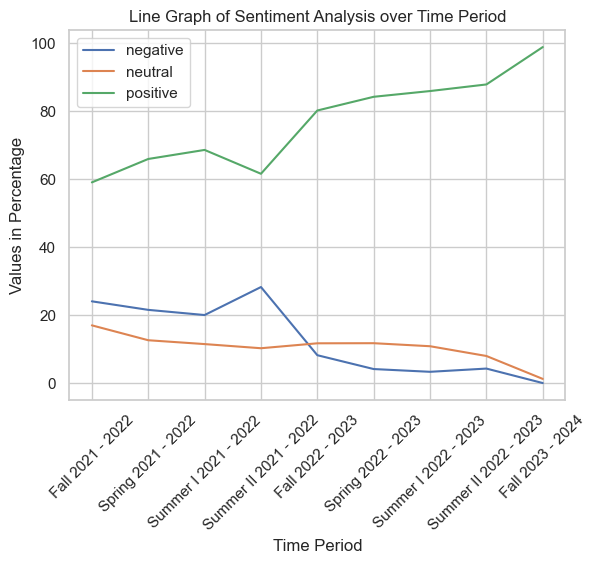

In [845]:
# Set the style of the graph (optional)
sns.set(style="whitegrid")

# Create the line plot
sns.lineplot(x='SemesterName', y='negative', data=semester_sentiment_counts, label='negative')
sns.lineplot(x='SemesterName', y='neutral', data=semester_sentiment_counts, label='neutral')
sns.lineplot(x='SemesterName', y='positive', data=semester_sentiment_counts, label='positive')

# Set labels and title
plt.xlabel('Time Period')
plt.ylabel('Values in Percentage')
plt.title('Line Graph of Sentiment Analysis over Time Period')

# Show the legend
plt.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()


# Sentiment Analysis - Overall Students

In [ ]:
# Group by 'ParticipantId' and count sentiment values
student_sentiment_counts = sorted_df.groupby(['ParticipantID', 'Sentiments']).size().unstack(fill_value=0)

In [ ]:
# Define a function to get the column name with the biggest value
def get_max_column(row):
    return row.idxmax()

# Apply the function to each row and store the result in a new column
student_sentiment_counts['OverallSentiment'] = student_sentiment_counts.apply(get_max_column, axis=1)

In [ ]:
student_sentiment_counts

In [652]:
category_counts = sorted_df['Sentiments'].value_counts()
category_counts

positive    123559
negative     23773
neutral      21516
Name: Sentiments, dtype: int64

In [654]:
category_percentages = round((category_counts / len(sorted_df)) * 100, 2)
category_percentages

positive    73.18
negative    14.08
neutral     12.74
Name: Sentiments, dtype: float64

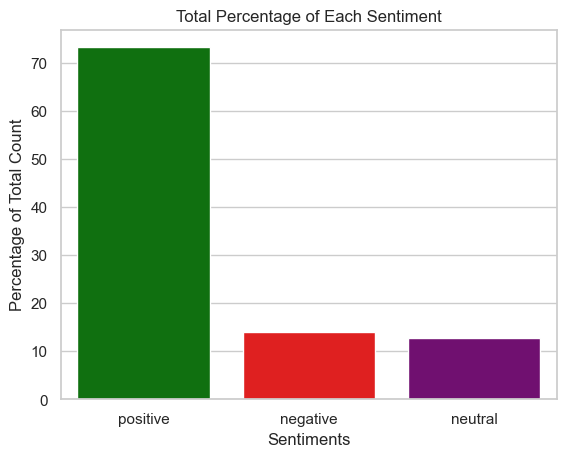

In [661]:
# Create a bar plot using Seaborn

cols = {'negative': 'red', 'positive': 'green', 'neutral': 'purple'}

sns.barplot(x=category_percentages.index,
            y=category_percentages.values,
            palette = cols)



# Set labels and title
plt.xlabel('Sentiments')
plt.ylabel('Percentage of Total Count')
plt.title('Total Percentage of Each Sentiment')

# Show the plot
plt.show()

# Sentiment Analysis - Student Programes

In [795]:
program_sentiment_counts = sorted_df.groupby(['StudentProgram', 'Sentiments']).size().unstack(fill_value=0).reset_index()
program_sentiment_counts.rename_axis(None, axis=1, inplace=True)

In [806]:
program_sentiment_percentages=pd.concat([program_sentiment_counts['StudentProgram'], round((program_sentiment_counts['negative'] / program_sentiment_counts.sum(axis=1)) * 100, 2),
 round((program_sentiment_counts['neutral'] / program_sentiment_counts.sum(axis=1)) * 100, 2),
 round((program_sentiment_counts['positive'] / program_sentiment_counts.sum(axis=1)) * 100, 2)],axis=1)
program_sentiment_percentages.rename(columns={0:'negative',1:'neutral',2:'positive'},inplace=True)

In [810]:
program_sentiment_percentages

,StudentProgram,negative,neutral,positive
0,Bachelor of Arts in Media and Mass Communication,15.35,14.02,70.63
1,Bachelor of Arts in Security and Strategic Stu...,11.35,12.75,75.90
2,Bachelor of Business Administration,14.09,13.67,72.24
3,Bachelor of Education,6.79,8.78,84.43
4,Bachelor of Law,17.50,10.36,72.14
5,Bachelor of Public Relations,15.13,11.13,73.74
6,Bachelor of Science in Computer Science,12.22,15.76,72.02
7,Bachelor of Science in Design - Digital Animation,8.44,16.83,74.73
8,Bachelor of Science in Design - Fashion Design,9.56,16.51,73.93
9,Bachelor of Science in Design - Graphic Design,8.24,12.27,79.49


In [811]:
midpoint = len(program_sentiment_percentages) // 2

# Split the DataFrame into two halves
first_half = program_sentiment_percentages.iloc[:midpoint, :]
second_half = program_sentiment_percentages.iloc[midpoint:, :]

In [812]:
# Melt the DataFrame to long format
pr_melted_first = pd.melt(first_half, id_vars=['StudentProgram'], value_vars=['negative', 'neutral', 'positive'], var_name='Sentiments', value_name='Percentage')

In [813]:
pr_melted_first

,StudentProgram,Sentiments,Percentage
0,Bachelor of Arts in Media and Mass Communication,negative,15.35
1,Bachelor of Arts in Security and Strategic Stu...,negative,11.35
2,Bachelor of Business Administration,negative,14.09
3,Bachelor of Education,negative,6.79
4,Bachelor of Law,negative,17.50
5,Bachelor of Public Relations,negative,15.13
6,Bachelor of Science in Computer Science,negative,12.22
7,Bachelor of Science in Design - Digital Animation,negative,8.44
8,Bachelor of Science in Design - Fashion Design,negative,9.56
9,Bachelor of Science in Design - Graphic Design,negative,8.24


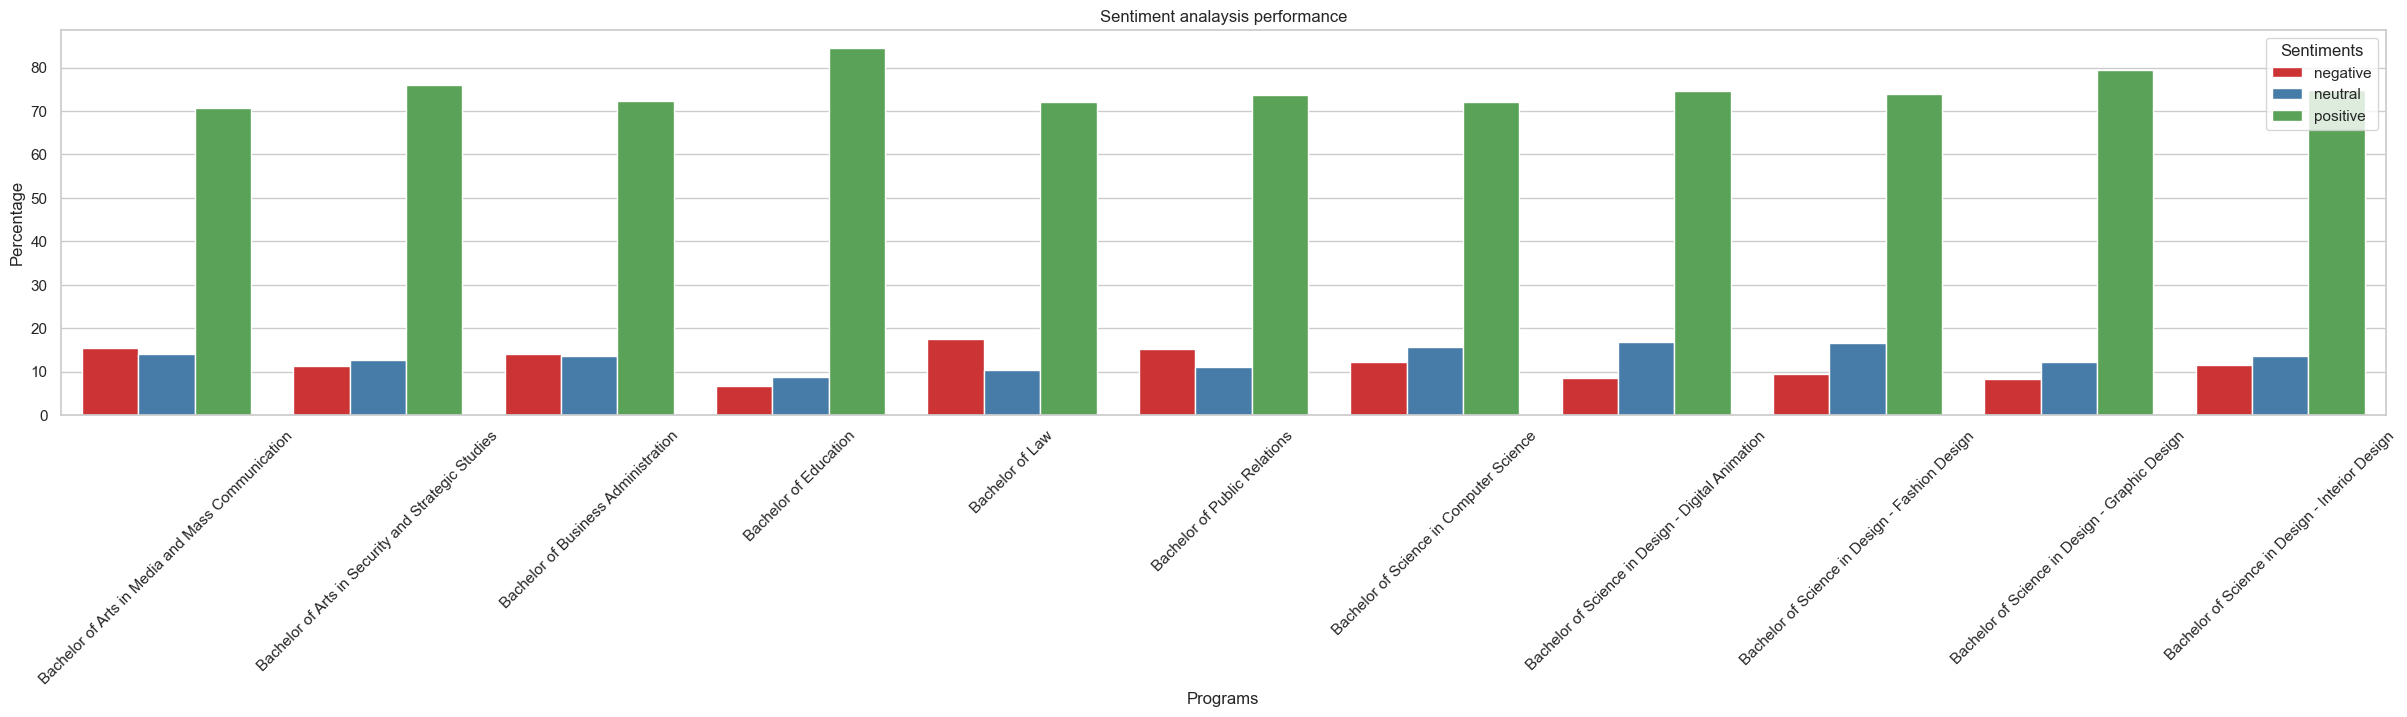

In [864]:
# Create a Seaborn bar plot with multiple bars
plt.figure(figsize=(30, 5))
sns.barplot(data=pr_melted_first, x='StudentProgram', y='Percentage', hue='Sentiments', palette='Set1')

# Add labels and title
plt.xlabel('Programs')
plt.ylabel('Percentage')
plt.title('Sentiment analaysis performance')
# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.legend(title='Sentiments', loc='upper right')
plt.show()

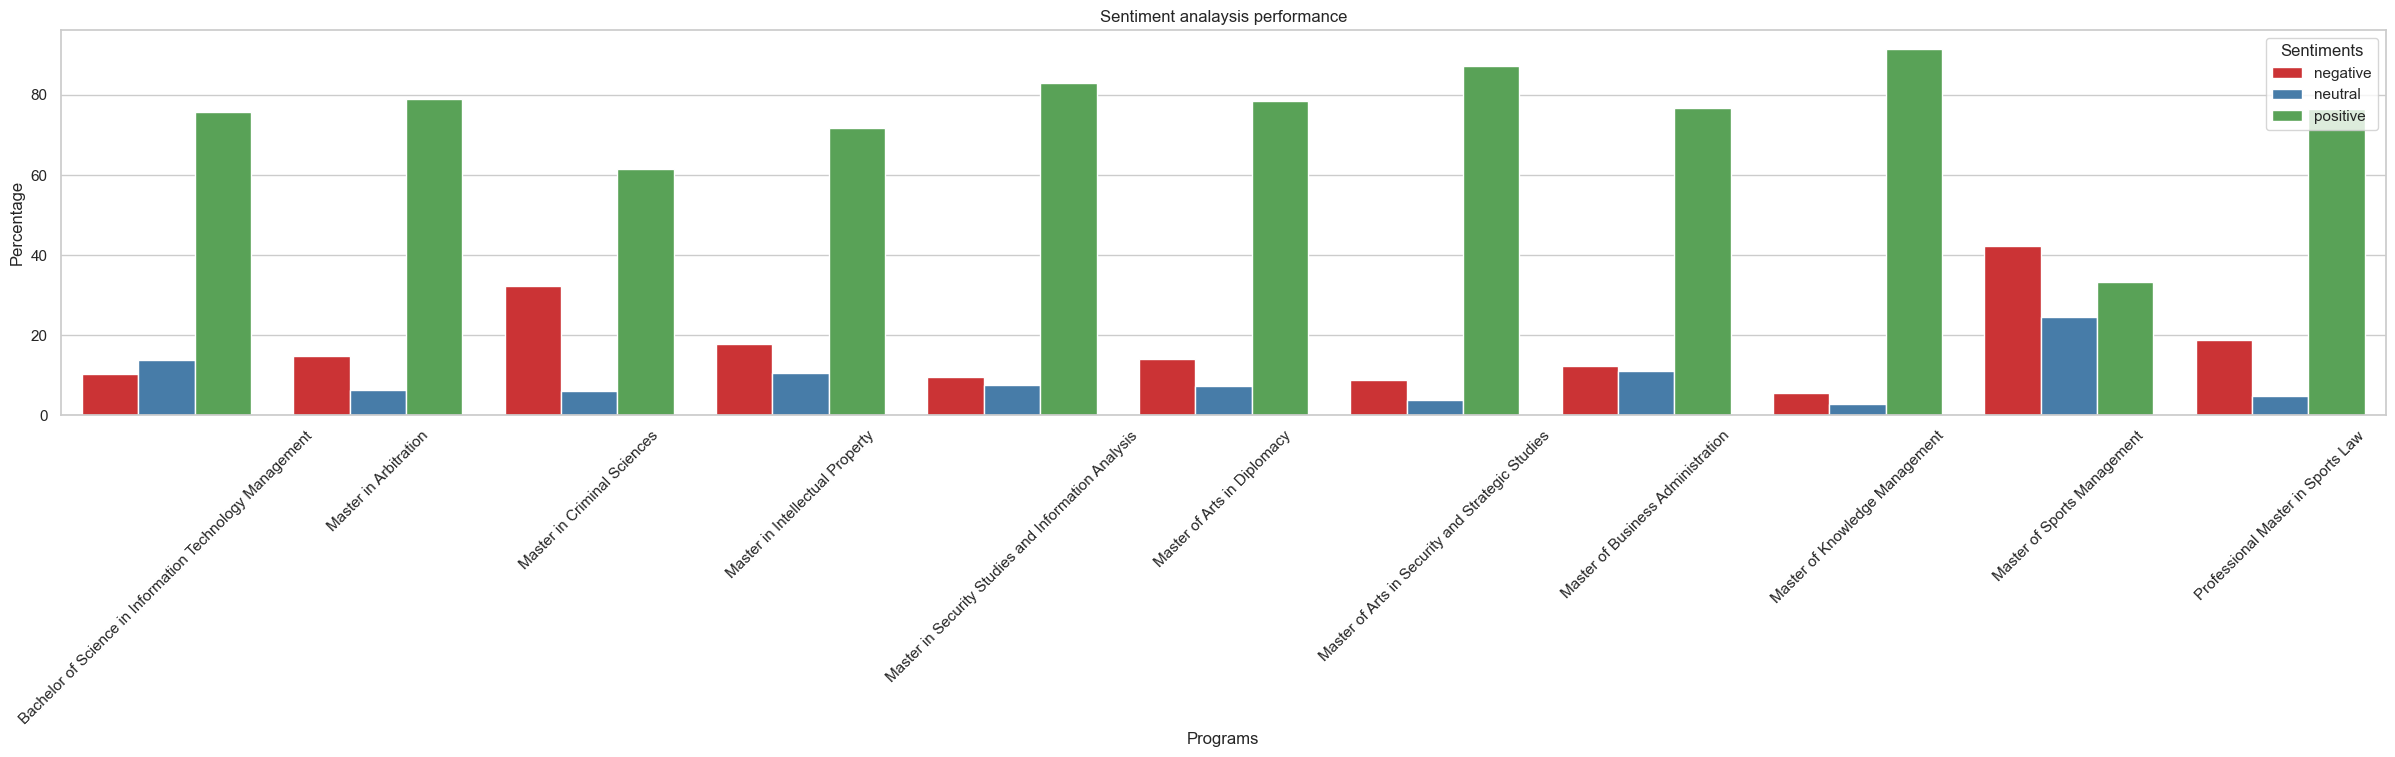

In [863]:
# Melt the DataFrame to long format
pr_melted_second = pd.melt(second_half, id_vars=['StudentProgram'], value_vars=['negative', 'neutral', 'positive'], var_name='Sentiments', value_name='Percentage')
# Create a Seaborn bar plot with multiple bars
plt.figure(figsize=(30, 5))
sns.barplot(data=pr_melted_second, x='StudentProgram', y='Percentage', hue='Sentiments', palette='Set1')

# Add labels and title
plt.xlabel('Programs')
plt.ylabel('Percentage')
plt.title('Sentiment analaysis performance')
# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.legend(title='Sentiments', loc='upper right')
plt.show()

# Sentiment Analysis - Degree Level

In [1051]:
# Group by 'DegreeLevel' and count sentiment values
degree_sentiment_counts = sorted_df.groupby(['DegreeLevel', 'Sentiments']).size().unstack(fill_value=0)

In [1052]:
degree_sentiment_counts

Sentiments,negative,neutral,positive
DegreeLevel,,,
Bachelor,21182,20426,113424
Master,2401,944,9314
Non-Degree,190,146,821


In [772]:
degree_sentiment_percentages=pd.concat([round((degree_sentiment_counts['negative'] / degree_sentiment_counts.sum(axis=1)) * 100, 2),
 round((degree_sentiment_counts['neutral'] / degree_sentiment_counts.sum(axis=1)) * 100, 2),
 round((degree_sentiment_counts['positive'] / degree_sentiment_counts.sum(axis=1)) * 100, 2)],axis=1).reset_index()
degree_sentiment_percentages.rename(columns={0:'negative',1:'neutral',2:'positive'},inplace=True)

In [773]:
degree_sentiment_percentages

,DegreeLevel,negative,neutral,positive
0,Bachelor,10.60,11.84,77.56
1,Master,14.84,7.19,77.98
2,Non-Degree,12.87,11.64,75.49


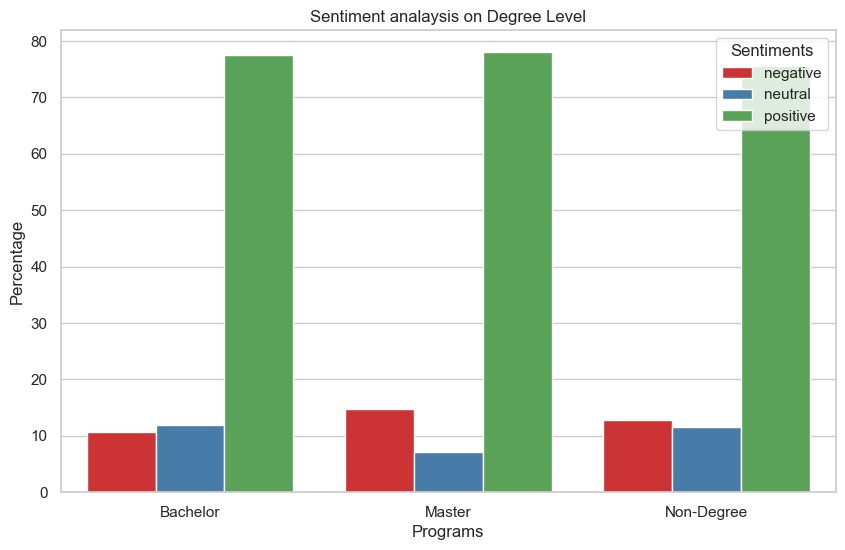

In [865]:
# Melt the DataFrame to long format
deg_melted = pd.melt(degree_sentiment_percentages, id_vars=['DegreeLevel'], value_vars=['negative', 'neutral', 'positive'], var_name='Sentiments', value_name='Percentage')
# Create a Seaborn bar plot with multiple bars
plt.figure(figsize=(10, 6))
sns.barplot(data=deg_melted, x='DegreeLevel', y='Percentage', hue='Sentiments', palette='Set1')

# Add labels and title
plt.xlabel('Programs')
plt.ylabel('Percentage')
plt.title('Sentiment analaysis on Degree Level')
# # Rotate x-axis labels for better readability (optional)
# plt.xticks(rotation=45)

# Show the plot
plt.legend(title='Sentiments', loc='upper right')
plt.show()

In [1053]:
degree_sentiment_counts.value_counts()

negative  neutral  positive
190       146      821         1
2401      944      9314        1
21182     20426    113424      1
dtype: int64

In [1084]:
b_deg_df = sorted_df[sorted_df['DegreeLevel'] == 'Bachelor']['Sentiments']
b_deg_df = b_deg_df.value_counts()
b_deg_df = b_deg_df[['neutral', 'negative', 'positive']]

In [1095]:
m_deg_df = sorted_df[sorted_df['DegreeLevel'] == 'Master']['Sentiments']
m_deg_df = m_deg_df.value_counts()
m_deg_df = m_deg_df[['neutral', 'negative', 'positive']]

In [1096]:
n_deg_df = sorted_df[sorted_df['DegreeLevel'] == 'Non-Degree']['Sentiments']
n_deg_df = n_deg_df.value_counts()
n_deg_df = n_deg_df[['neutral', 'negative', 'positive']]

([<matplotlib.patches.Wedge at 0x2e65f73d0>,
 [Text(1.0146887799460977, 0.42474307510717557, 'neutral'),
  Text(0.3237970670553589, 1.2073340297392217, 'negative'),
  Text(-0.6730880562438536, -0.8700301538118498, 'positive')],
 [Text(0.553466607243326, 0.2316780409675503, '12.6%'),
  Text(0.19427824023321533, 0.7244004178435328, '16.4%'),
  Text(-0.3671389397693746, -0.47456190207919074, '71.0%')])

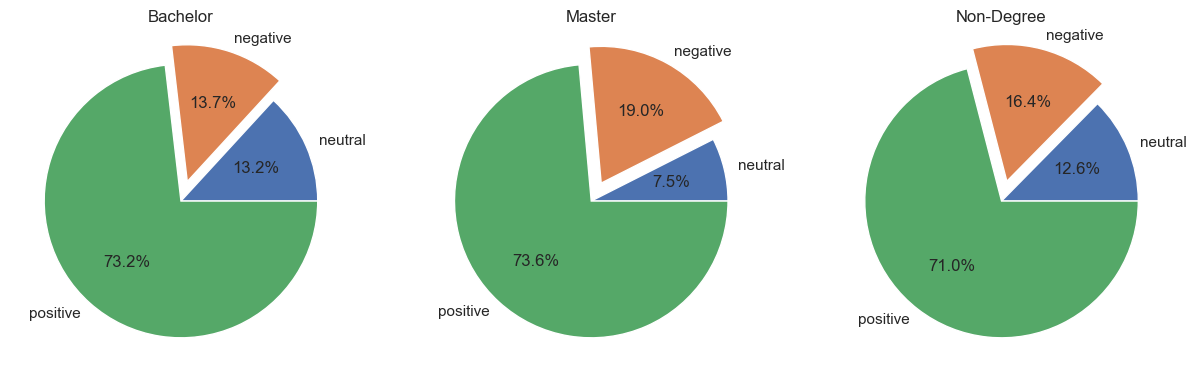

In [1097]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.title("Bachelor")
plt.pie(b_deg_df.values, labels = b_deg_df.index, explode = (0, 0.15, 0), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,2)
plt.title("Master")
plt.pie(m_deg_df.values, labels = m_deg_df.index, explode = (0, 0.15, 0), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,3)
plt.title("Non-Degree")
plt.pie(n_deg_df.values, labels = n_deg_df.index, explode = (0, 0.15, 0), autopct='%1.1f%%', shadow=False)



# Top 5 Questions Text

In [1039]:
qt_sentiment_counts = sorted_df.groupby(['QuestionText', 'Sentiments']).size().unstack(fill_value=0)

In [1040]:
qt_sentiment_counts = qt_sentiment_counts.sort_values(by=['negative'], ascending=False)

In [1041]:
top5qt_sentiment_counts = qt_sentiment_counts.head(5).reset_index()

In [1048]:
top5qt_sentiment_counts.to_csv('top5qt_sentiment_counts.csv')

In [1043]:
top5qt_sentiment_counts.rename_axis(None, axis=1, inplace=True)

In [1046]:
3832/(3832 + 3362 + 10159)*100

22.082637008010142

In [1044]:
# Melt the DataFrame to long format
top5qt_melted = pd.melt(top5qt_sentiment_percentages, id_vars=['QuestionText'], value_vars=['negative', 'neutral', 'positive'], var_name='Sentiments', value_name='Total')

In [1045]:
top5qt_melted

,QuestionText,Sentiments,Total
0,The coursework and assignments are challenging,negative,22.08
1,The course is relevant to my program of study,negative,15.12
2,The faculty uses additional resources (other t...,negative,14.09
3,Course learning materials are available on the...,negative,12.95
4,The faculty discussed the course syllabus at t...,negative,12.65
5,The coursework and assignments are challenging,neutral,19.37
6,The course is relevant to my program of study,neutral,11.80
7,The faculty uses additional resources (other t...,neutral,11.22
8,Course learning materials are available on the...,neutral,8.84
9,The faculty discussed the course syllabus at t...,neutral,8.22


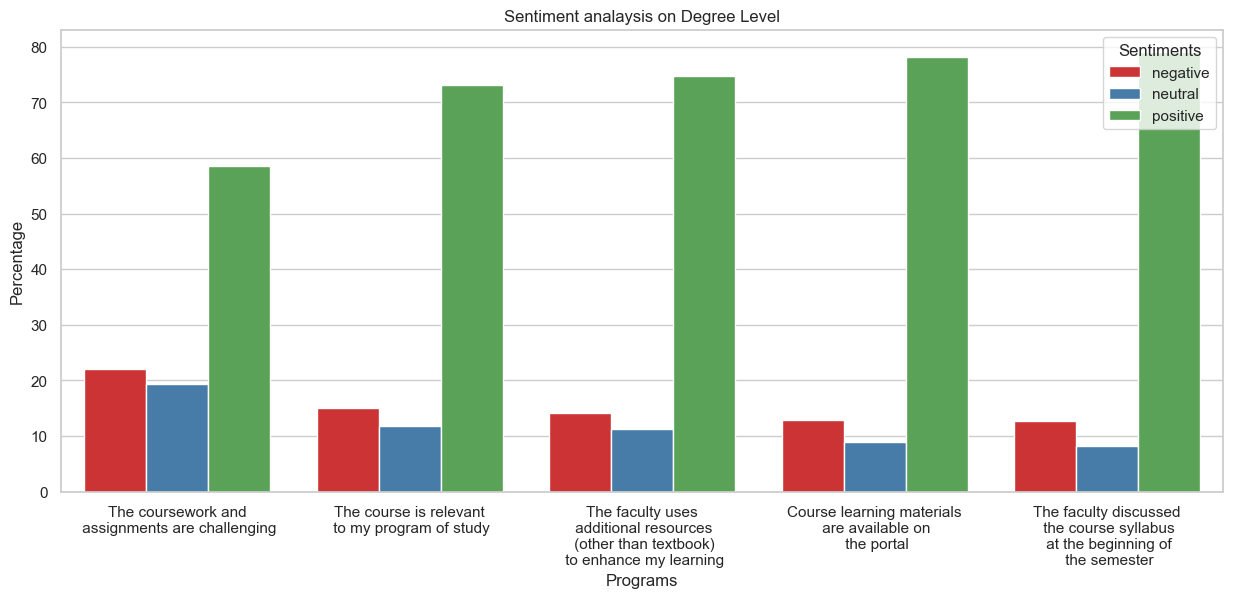

In [1036]:

# Create a Seaborn bar plot with multiple bars
plt.figure(figsize=(15, 6))
sns.barplot(data=top5qt_melted, x='QuestionText', y='Total', hue='Sentiments', palette='Set1')

# Add labels and title
plt.xlabel('Programs')
plt.ylabel('Percentage')
plt.title('Sentiment analaysis on Degree Level')
# # Rotate x-axis labels for better readability (optional)
# plt.xticks(rotation=45)

# Define custom tick labels with line breaks for wrapping
custom_labels = ['The coursework and\n assignments are challenging', 
                 'The course is relevant\n to my program of study',
                 'The faculty uses\n additional resources\n (other than textbook)\n to enhance my learning',
                 'Course learning materials\n are available on\n the portal',
                'The faculty discussed\n the course syllabus\n at the beginning of\n the semester']

# Set custom tick labels for the x-axis
plt.xticks(range(len(custom_labels)), custom_labels)

# Show the plot
plt.legend(title='Sentiments', loc='upper right')
plt.show()

# TextBlob Vs Vader Vs RoBERTa Models Comparison

In [111]:
# # # TF
# # model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
# # model.save_pretrained(MODEL)
# # text = "Covid cases are increasing fast!"
# # encoded_input = tokenizer(text, return_tensors='tf')
# # output = model(encoded_input)
# # scores = output[0][0].numpy()
# # scores = softmax(scores)
# # Print labels and scores
# ranking = np.argsort(scores)
# ranking = ranking[::-1]
# for i in range(scores.shape[0]):
#     l = config.id2label[ranking[i]]
#     s = scores[ranking[i]]
#     print(f"{i+1}) {l} {np.round(float(s), 4)} {ranking[i]}")

1) positive 0.8759 2
2) neutral 0.1068 1
3) negative 0.0173 0


In [441]:
rob_counts = reviews_df_f['rob_Analysis'].value_counts()
rob_counts

neutral     3893
positive    1174
negative     156
Name: rob_Analysis, dtype: int64

In [506]:
rv_df = reviews_df_f[['tb_Analysis', 'v_Analysis', 'rob_Analysis']]

In [507]:
# Stack the DataFrame to combine all columns into one
stacked_df = rv_df.stack()

In [508]:
stacked_df

32      tb_Analysis     neutral
        v_Analysis      neutral
        rob_Analysis    neutral
93      tb_Analysis     neutral
        v_Analysis      neutral
                         ...   
180948  v_Analysis      neutral
        rob_Analysis    neutral
180961  tb_Analysis     neutral
        v_Analysis      neutral
        rob_Analysis    neutral
Length: 15669, dtype: object

In [527]:

# Create a pivot table with counts
pivot_table = pd.pivot_table(stacked_df.reset_index(), 
                             index=[0], 
                             columns=['level_1'], 
                             aggfunc='size')

# Rename the index and columns for clarity (optional)
pivot_table.index.name = ''
pivot_table.columns.name = ''

# Display the pivot table
print(pivot_table)

          rob_Analysis  tb_Analysis  v_Analysis
                                               
negative           156           83         116
neutral           3893         4061        3846
positive          1174         1079        1261


In [540]:
pivot_table_t = pivot_table.T 

In [541]:
pivot_table_t.index

Index(['rob_Analysis', 'tb_Analysis', 'v_Analysis'], dtype='object', name='')

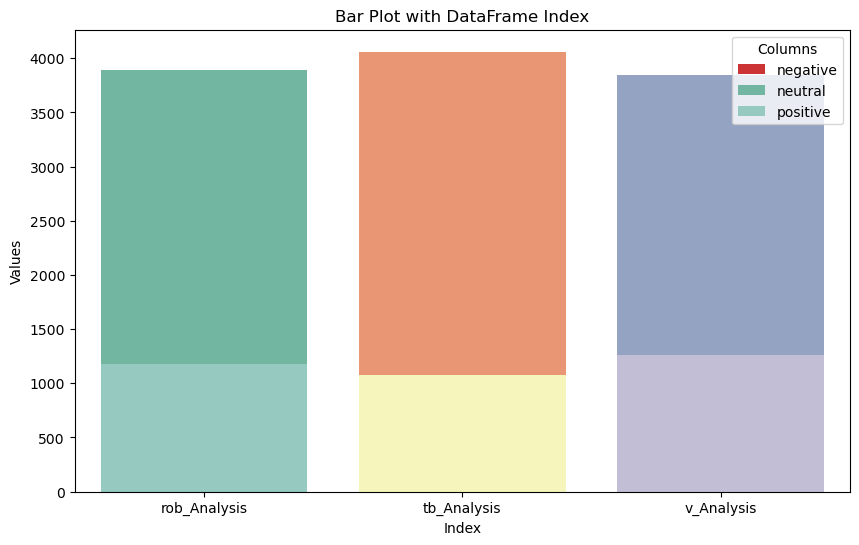

In [545]:

# Create a Seaborn bar plot
plt.figure(figsize=(10, 6))

# Using 'x' for the index and 'y' for the columns
sns.barplot(data=pivot_table_t, x=pivot_table_t.index, y='negative', palette='Set1', label='negative')
sns.barplot(data=pivot_table_t, x=pivot_table_t.index, y='neutral', palette='Set2', label='neutral')
sns.barplot(data=pivot_table_t, x=pivot_table_t.index, y='positive', palette='Set3', label='positive')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Bar Plot with DataFrame Index')

# Show the plot
plt.legend(title='Columns')
plt.show()

In [547]:
pivot_table_t['models'] = pivot_table_t.index

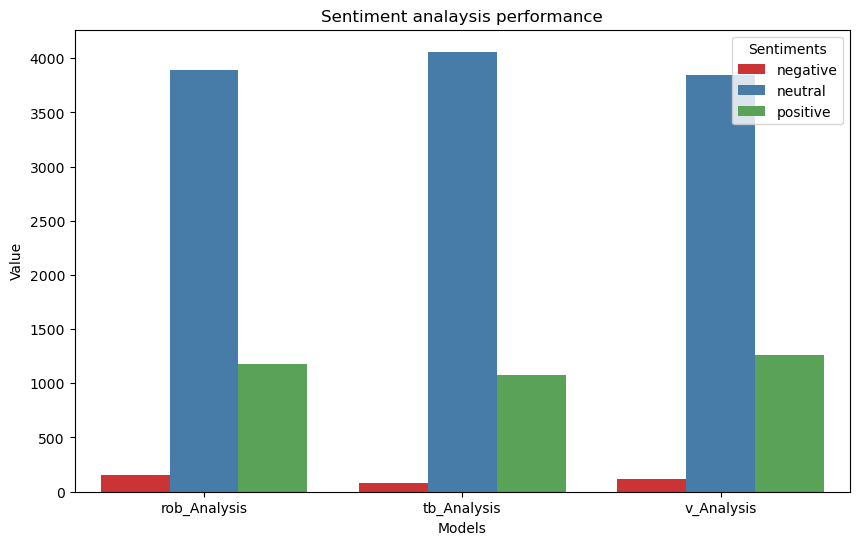

In [549]:
# Melt the DataFrame to long format
melted_df = pd.melt(pivot_table_t, id_vars=['models'], value_vars=['negative', 'neutral', 'positive'], var_name='Value_Column', value_name='Value')

# Create a Seaborn bar plot with multiple bars
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x='models', y='Value', hue='Value_Column', palette='Set1')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Value')
plt.title('Sentiment analaysis performance')

# Show the plot
plt.legend(title='Sentiments', loc='upper right')
plt.show()

# Topic Modeling

# Latent Dirichlet Allocation (LDA)

Latent Dirichlet Allocation (LDA) is used as a modelling technique that can classify text in a document to a particular topic. It uses Dirichlet distribution to find topics for each document model and words for each topic model.

### Implementation

In [1126]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = cv.fit_transform(reviews_df['ParticipantResponse'])

### LDA Model

In [1127]:
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=7,random_state=42)
LDA.fit(dtm)

LatentDirichletAllocation(n_components=7, random_state=42)

In [1128]:
vocab = cv.get_feature_names_out()

In [1131]:
len(vocab)

886

### Showing Stored Words:

In [1132]:
for i in range(10):
    random_word_id = random.randint(0,886)
    print(vocab[random_word_id])

firas
suggestions
books
cases
speak
strongly
able
shows
studying
gaurav


### Showing top words per topic

In [1134]:
len(LDA.components_)

7

In [1135]:
len(LDA.components_[0])

886

In [1136]:
single_topic = LDA.components_[0]

In [1137]:
# Returns the indices that would sort this array.
single_topic.argsort()

array([288, 291, 679, 795, 103, 654, 191,  12,  82, 132, 532,  16, 668,
       174, 494, 655, 612, 762, 789, 613,  48, 822, 189, 369,  76,  24,
       624,  79, 395, 298,   1, 642, 360, 781,  92, 142, 211,  10, 737,
       732, 656, 609, 696, 393,  90, 540, 128, 833, 621, 501, 199, 531,
       183, 304, 566, 541, 467, 715, 104, 823, 662, 766, 815,  25, 842,
       575, 460, 638, 720, 254, 733, 228, 854, 220, 864, 686, 757, 169,
        20, 266, 214, 499, 176, 337, 311, 262, 147, 567, 190, 121,  52,
       769, 239,   3, 821, 648, 141, 712, 525, 640, 726, 210, 309, 537,
       245,  88,  37, 834, 755, 340, 317, 390, 207, 186, 231, 230, 152,
        27, 632, 539,  68, 676, 884, 375, 153, 466, 371, 478, 229, 274,
       225,  38, 109, 500, 814, 866, 736, 117, 785, 576, 431, 817, 146,
       673,  86, 497, 604, 577, 240, 483, 306, 342, 727, 601, 851, 671,
       714, 208, 234, 178, 401, 653, 819, 129, 215,  61, 357, 198, 120,
       270, 883, 392, 463, 430, 559, 635, 700, 349, 841, 268, 71

In [1138]:
# Top 10 words for this topic:
single_topic.argsort()[-10:]

array([446, 206, 209, 469, 447, 409, 742, 741, 631, 154])

In [1139]:
top_word_indices = single_topic.argsort()[-10:]
for index in top_word_indices:
    print(cv.get_feature_names_out()[index])

learn
don
dr
lot
learned
interesting
students
student
recommendations
course


We will perform .transform() on our vectorized UserComments to attach a label number. But before, we view all the topics found.

In [1140]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['work', 'instructor', 'life', 'information', 'like', 'learn', 'don', 'dr', 'lot', 'learned', 'interesting', 'students', 'student', 'recommendations', 'course']


THE TOP 15 WORDS FOR TOPIC #1
['need', 'students', 'like', 'workshops', 'materials', 'book', 'exam', 'fine', 'doctor', 'dr', 'suggestion', 'neutral', 'course', 'thanks', 'perfect']


THE TOP 15 WORDS FOR TOPIC #2
['words', 'covered', 'amer', 'drawing', 'project', 'hope', 'dr', 'strongly', 'agree', 'know', 'explain', 'students', 'nope', 'does', 'suggestions']


THE TOP 15 WORDS FOR TOPIC #3
['did', 'help', 'lot', 'lessons', 'instructor', 'teaching', 'like', 'assignments', 'course', 'understand', 'class', 'work', 'university', 'dr', 'students']


THE TOP 15 WORDS FOR TOPIC #4
['way', 'doctor', 'courses', 'add', 'nil', 'class', 'professor', 'really', 'classes', 'na', 'dr', 'clear', 'course', 'thank', 'great']


THE TOP 15 WORDS FOR TOPIC #5
['explained', 'recommend', 'semester', 'job', 'enjoyed', 't

### Attaching Discovered Topic Labels to Original Articles

In [1142]:
topic_results = LDA.transform(dtm)
reviews_df['Topic'] = topic_results.argmax(axis=1)

In [1146]:
reviews_df.loc[reviews_df['ParticipantResponse'].str.contains("doctor"), ['ParticipantResponse', 'Sentiments', 'Topic']]

,ParticipantResponse,Sentiments,Topic
2783,nothing but a good doctor who explains the cou...,negative,1
2800,i wish that the doctor do more than just readi...,neutral,3
8489,amazing doctor,positive,6
12522,amazing doctor clear materials and speech,positive,6
16656,i really liked the course sooo much and doctor...,positive,4
...,...,...,...
176911,best doctor,positive,6
176950,dr david is an amazing doctor and well respect...,positive,0
178312,the best doctor,positive,6
178415,the doctor have a vary uniq way to make me und...,positive,6


In [ ]:
reviews_df.loc[(df['ParticipantResponse'].str.contains("suggestion")), ['ParticipantResponse', 'sentiment_score', 'Topic']]

# Topic Modelling with LLama 2 Model

In [2]:
%%capture
!pip install bertopic datasets accelerate bitsandbytes xformers adjustText

In [5]:
!pip install transformers

In [2]:
# from huggingface_hub import notebook_login
# notebook_login()

In [1]:
# from torch import cuda

# model_id = 'meta-llama/Llama-2-13b-chat-hf'
# device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

# print(device)

cpu


In [2]:
# from torch import bfloat16
# import transformers

# # set quantization configuration to load large model with less GPU memory
# # this requires the `bitsandbytes` library

# bnb_config = transformers.BitsAndBytesConfig(
#     load_in_4bit=True,  # 4-bit quantization
#     bnb_4bit_quant_type='nf4',  # Normalized float 4
#     bnb_4bit_use_double_quant=True,  # Second quantization after the first
#     bnb_4bit_compute_dtype=bfloat16  # Computation type
# )

In [3]:
# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_folder_path)

Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.


In [7]:
# Llama 2 Model
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer

model_directory = "./llama/model"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_directory)
model = AutoModelForCausalLM.from_pretrained(model_directory)


# model_folder_path = 

# model = transformers.AutoModelForCausalLM.from_pretrained(
#     model_folder_path,
#     trust_remote_code=True,
# #     quantization_config=bnb_config,
#     device_map='auto',
# )
model.eval()

ImportError: cannot import name 'AutoModelForCausalLM' from 'transformers' (unknown location)

In [9]:
# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    do_sample=True,
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

In [13]:
aspect = "courses"
prompt = f"List common issues mentioned in user feedback regarding {aspect}."
input_ids = tokenizer.encode(prompt, return_tensors="pt")

# Generate insights for courses
output = model.generate(input_ids, max_length=150, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print(f"Insights for {aspect}:")
print(generated_text)


KeyboardInterrupt: 

In [12]:
prompt = "Could you explain to me how 4-bit quantization works as if I am 5?"
res = generator(prompt)
print(res[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


KeyboardInterrupt: 

In [ ]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""

In [ ]:
# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat
"""

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Replace with the path to your locally downloaded Llama 2 model directory
model_directory = "./llama/model"
tokenizer = AutoTokenizer.from_pretrained(model_directory)
model = AutoModelForCausalLM.from_pretrained(model_directory)

# Example prompt
prompt = "Once upon a time, in a land far, far away, there was a"

# Tokenize the prompt
input_ids = tokenizer.encode(prompt, return_tensors="pt")

# Generate text
output = model.generate(input_ids, max_length=50, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
!pip install --upgrade transformers